Import libraries

In [1]:
%%time
import warnings, pandas as pd, numpy as np, seaborn as sns, matplotlib.pyplot as plt, pickle
from sklearn.model_selection import train_test_split
from os import path
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.metrics import roc_auc_score
%matplotlib inline
from pylab import rcParams
from sklearn.metrics import f1_score, confusion_matrix, classification_report, accuracy_score, \
                            balanced_accuracy_score, roc_auc_score
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
warnings.filterwarnings("ignore")

CPU times: user 1.26 s, sys: 254 ms, total: 1.52 s
Wall time: 1.01 s


In [2]:
def evaluate_models(train_df1,test_df1,outcome_feature):
    X_train  = train_df1.loc[:,train_df1.columns != outcome_feature]
    y_train  = train_df1.loc[:,train_df1.columns == outcome_feature]
    X_test   = test_df1.loc[:,test_df1.columns != outcome_feature]
    y_test   = test_df1.loc[:,test_df1.columns == outcome_feature]

    seed = 1234
    names = ['Logistic','RandomForest','XGBoost','NaiveBayes','AdaBoost','MLP']
    classifiers = [LogisticRegression(random_state=seed, n_jobs=-1),
                   RandomForestClassifier(max_depth=10,n_estimators=100,random_state=seed,n_jobs=-1),
                   XGBClassifier(max_depth=10,random_state=seed,n_estimators=100,n_jobs=-1),
                   GaussianNB(),
                   AdaBoostClassifier(random_state=seed),
                   MLPClassifier(alpha=1, random_state=seed, max_iter=1000)
                  ]
    results_df, predictions_df, predict_proba_df = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()
    for name, clf in zip(names,classifiers):
        clf.fit(X_train, y_train)
        predictions_df[name] = clf.predict(X_test)
        predict_proba_df[name] = clf.predict_proba(X_test)[:,1]
    for name in names:
        temp_metrics = [f1_score(y_test,predictions_df[name],average=None).tolist()[1]]
        temp_metrics.append(balanced_accuracy_score(y_test,predictions_df[name]))
        temp_metrics.append(roc_auc_score(y_test,predict_proba_df[name]))
        results_df[name] = temp_metrics
    results_df = results_df.transpose().reset_index()    
    results_df = results_df.rename(columns={'index':'Model', 0:'Matching - F1', 1: 'Balanced Accuracy',
                                             2: 'ROC_AUC_SCORE'})
    results_df = results_df.sort_values(by=['Matching - F1'],ascending=False)
    return results_df

def perform_selectkbest(in_df,outcome_feature,test_type):
    X = in_df.loc[:,in_df.columns != outcome_feature]
    y = in_df.loc[:,in_df.columns == outcome_feature]
    if test_type == 'chi2':
        kbest = SelectKBest(score_func=chi2, k=10)
    else:
        kbest = SelectKBest(score_func=f_classif, k=10)
    fit = kbest.fit(X,y)
    features = fit.transform(X)
        
    temp_df = pd.DataFrame()
    temp_df['FeatureName'] = X.columns[fit.get_support()].to_list()
    temp_df['FeatureImportance'] = list(fit.scores_[fit.get_support()])
    temp_df.sort_values(by=['FeatureImportance'],ascending=False,inplace=True)
    return temp_df

def FeatureEngineering(temp_df):
    #Match Feature
    temp_df['Match'] = temp_df.apply(lambda row: 1 \
                                                if row['matched_transaction_id'] == row['feature_transaction_id'] \
                                                else 0, \
                                                axis = 1)
    #CompanyID OneHotEncoding
    temp_df = pd.concat([temp_df,pd.get_dummies(temp_df['company_id'],
                                                prefix='compid')],axis=1).drop('company_id',axis=1)
    
    #ReceiptMatchesCount
    receipt_counts = temp_df.groupby(['receipt_id']).size().to_dict()
    temp_df['ReceiptMatchesCount'] = temp_df.apply(lambda row: receipt_counts[row['receipt_id']],axis=1)
    
    feature_list = ['DateMappingMatch','AmountMappingMatch','DescriptionMatch',
                    'DifferentPredictedTime', 'TimeMappingMatch', 'PredictedNameMatch', 
                    'ShortNameMatch', 'DifferentPredictedDate', 'PredictedAmountMatch', 'PredictedTimeCloseMatch']
    
    #StatisticsFeatures
    mean_df   = temp_df.groupby(['receipt_id']).mean()
    median_df = temp_df.groupby(['receipt_id']).median()
    std_df    = temp_df.groupby(['receipt_id']).std()
    rank_df   = temp_df.groupby(['receipt_id']).rank(pct=True)
    for each_feature in feature_list:
        temp_dict = mean_df[each_feature].to_dict()
        temp_df[each_feature+'_mean']   = temp_df.apply(lambda row: temp_dict[row['receipt_id']],axis=1)
        temp_dict = median_df[each_feature].to_dict()
        temp_df[each_feature+'_median'] = temp_df.apply(lambda row: temp_dict[row['receipt_id']],axis=1)
        temp_dict = std_df[each_feature].to_dict()
        temp_df[each_feature+'_std']    = temp_df.apply(lambda row: temp_dict[row['receipt_id']],axis=1).fillna(0)
        temp_df[each_feature+'_rank']   = rank_df[each_feature]
        
    #Drop feature_transaction_id and matched_transaction_id columns
    temp_df.drop(['feature_transaction_id','matched_transaction_id'],axis=1,inplace=True)
    return temp_df

Load file

In [3]:
%%time
in_df = pd.read_csv("data.csv",delimiter=':', thousands=',')
print("Number of records:", in_df.shape[0], ", Number of columns:", in_df.shape[1])
print("Data Types listing:\n",in_df.dtypes.value_counts())
print("\n\nList of columns\n",'\n'.join(in_df.columns.tolist()))

Number of records: 12034 , Number of columns: 14
Data Types listing:
 float64    10
int64       4
dtype: int64


List of columns
 receipt_id
company_id
matched_transaction_id
feature_transaction_id
DateMappingMatch
AmountMappingMatch
DescriptionMatch
DifferentPredictedTime
TimeMappingMatch
PredictedNameMatch
ShortNameMatch
DifferentPredictedDate
PredictedAmountMatch
PredictedTimeCloseMatch
CPU times: user 20.4 ms, sys: 6.39 ms, total: 26.8 ms
Wall time: 24.8 ms


Explore data and initial analysis

In [4]:
%%time
in_df.head()

CPU times: user 564 µs, sys: 234 µs, total: 798 µs
Wall time: 712 µs


,receipt_id,company_id,matched_transaction_id,feature_transaction_id,DateMappingMatch,AmountMappingMatch,DescriptionMatch,DifferentPredictedTime,TimeMappingMatch,PredictedNameMatch,ShortNameMatch,DifferentPredictedDate,PredictedAmountMatch,PredictedTimeCloseMatch
0,10000,10000,10468,10000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1,10000,10000,10468,10001,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,10000,10000,10468,10003,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3,10000,10000,10468,10004,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
4,10000,10000,10468,10005,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


Missing Value Analysis

In [5]:
%%time
in_df.isnull().sum()

CPU times: user 2.44 ms, sys: 1.41 ms, total: 3.85 ms
Wall time: 2.59 ms


receipt_id                 0
company_id                 0
matched_transaction_id     0
feature_transaction_id     0
DateMappingMatch           0
AmountMappingMatch         0
DescriptionMatch           0
DifferentPredictedTime     0
TimeMappingMatch           0
PredictedNameMatch         0
ShortNameMatch             0
DifferentPredictedDate     0
PredictedAmountMatch       0
PredictedTimeCloseMatch    0
dtype: int64

Looks like no missing values in the data

Lets check the number of unique receipts and company ids

In [6]:
%%time
print("#receipt ids - ", len(in_df['receipt_id'].unique()),"\n#company ids - ", len(in_df['company_id'].unique()))

#receipt ids -  1155 
#company ids -  5
CPU times: user 1.17 ms, sys: 687 µs, total: 1.86 ms
Wall time: 1.22 ms


- Lets check the average number of partial matches for each receipt
- Also lets check the representation of receipts per each company id

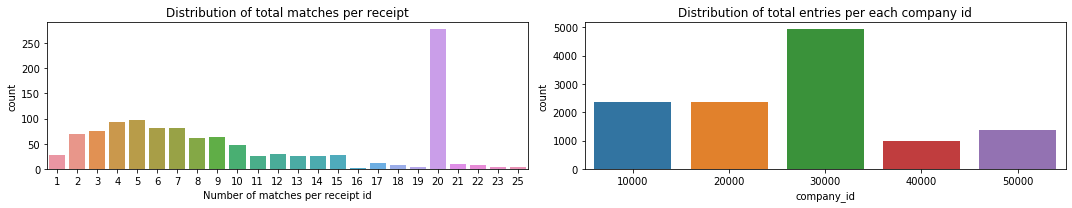

CPU times: user 600 ms, sys: 87.6 ms, total: 688 ms
Wall time: 528 ms


In [7]:
%%time
rcParams['figure.figsize'] = 15, 3; fig, axes = plt.subplots(1,2)
ax = axes[0]; sns.countplot(in_df['receipt_id'].value_counts(),ax=ax)
ax.set_xlabel("Number of matches per receipt id"); ax.set_title("Distribution of total matches per receipt")
ax = axes[1]; sns.countplot(in_df['company_id'],ax=ax)
ax.set_title("Distribution of total entries per each company id")
plt.tight_layout(); plt.show()

Observations:
    - Close to 270 receipt ids have 20 partial matches, while a lot of receipts have lower density of matches
    - CompanyID 3000 has highest representation of receipts and 4000 CompanyID with the least representation

Lets see the distribution of Features among matching transactions and unmatching transactions

Number of matching entries: 857 
Number of non-matching entries: 11177


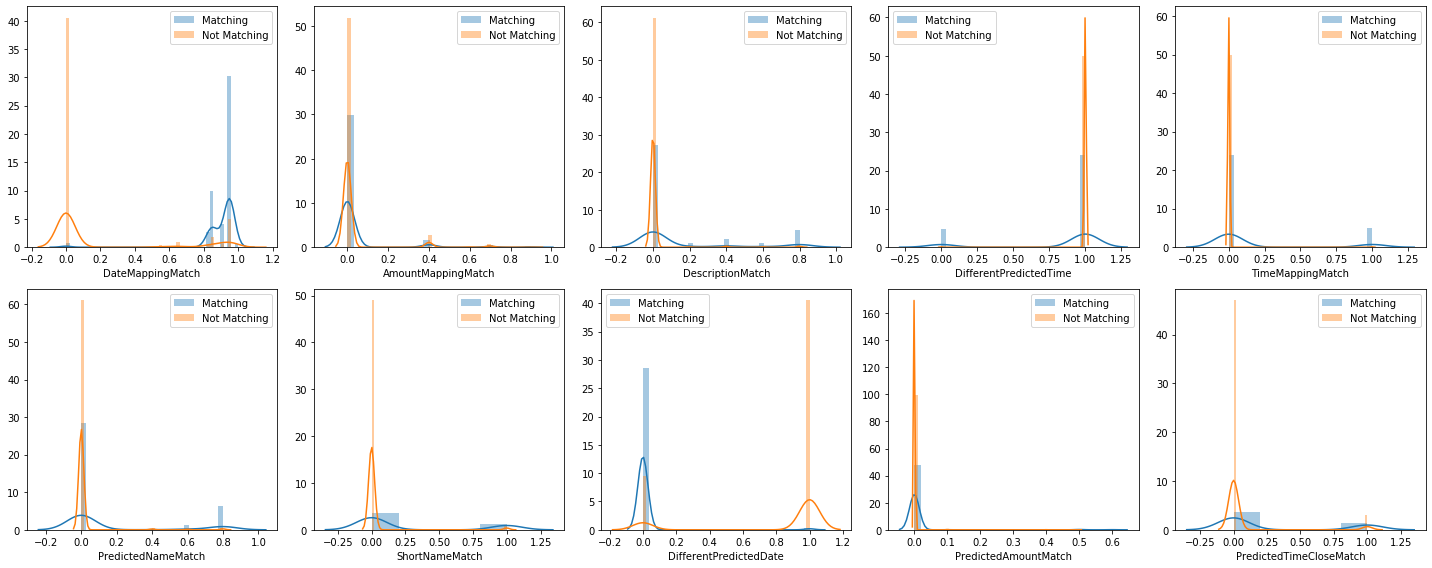

CPU times: user 5.2 s, sys: 469 ms, total: 5.67 s
Wall time: 3.42 s


In [8]:
%%time
match_df = in_df[in_df['matched_transaction_id'] == in_df['feature_transaction_id']]
notmatch_df = in_df[in_df['matched_transaction_id'] != in_df['feature_transaction_id']]
print("Number of matching entries:", match_df.shape[0], "\nNumber of non-matching entries:", notmatch_df.shape[0])

rcParams['figure.figsize'] = 20, 8; fig, axes = plt.subplots(2,5)
feature_cols = ['DateMappingMatch','AmountMappingMatch','DescriptionMatch','DifferentPredictedTime',
                'TimeMappingMatch', 'PredictedNameMatch', 'ShortNameMatch', 'DifferentPredictedDate',
                'PredictedAmountMatch', 'PredictedTimeCloseMatch']
i = j = 0
for each_col in feature_cols:
    ax = axes[i][j]; sns.distplot(match_df[each_col],label='Matching',ax=ax);
    sns.distplot(notmatch_df[each_col],label='Not Matching',ax=ax); ax.legend(loc='best')
    j += 1
    if j == 5:
        i += 1; j = 0

plt.tight_layout(); plt.show()

Split Train and Test Data

In [9]:
%%time
test_ratio = 0.3
total_receipts = len(in_df['receipt_id'].unique())
test_receipt_count = round(total_receipts*test_ratio)
train_receipt_count = total_receipts - test_receipt_count
print("Total receipts:", total_receipts, ", Training#:", train_receipt_count,", validation#:",test_receipt_count)

Total receipts: 1155 , Training#: 809 , validation#: 346
CPU times: user 1.38 ms, sys: 891 µs, total: 2.28 ms
Wall time: 1.47 ms


Make sure the records are split according to random sampling of receipts

In [10]:
%%time
seed1 = 123
np.random.seed(seed1)
train_receipts = np.random.choice(in_df['receipt_id'].unique(),train_receipt_count,replace=False).tolist()
test_receipts = [x for x in in_df['receipt_id'].unique().tolist() if x not in train_receipts]
print((len(train_receipts) == train_receipt_count) & (len(test_receipts) == test_receipt_count))

train_df = in_df[in_df['receipt_id'].isin(train_receipts)]
test_df = in_df[in_df['receipt_id'].isin(test_receipts)]

True
CPU times: user 11.4 ms, sys: 1.49 ms, total: 12.9 ms
Wall time: 11.7 ms


- Check the distribution of receipts vs number of matches both in train and test
- This will ensure that some receipts with high/low number of matches dont end up wholly in train/test

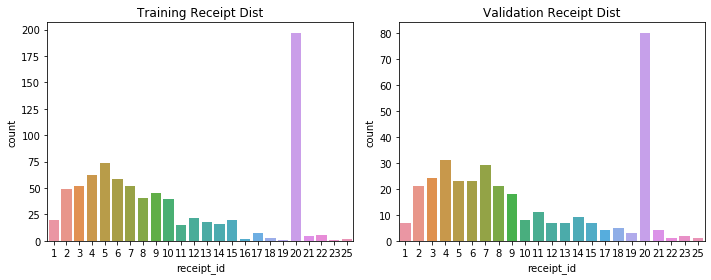

CPU times: user 699 ms, sys: 77.8 ms, total: 777 ms
Wall time: 596 ms


In [11]:
%%time
rcParams['figure.figsize'] = 10, 4; fig, axes = plt.subplots(1,2)
ax = axes[0]; sns.countplot(train_df['receipt_id'].value_counts(),ax=ax); ax.set_title('Training Receipt Dist')
ax = axes[1]; sns.countplot(test_df['receipt_id'].value_counts(),ax=ax); ax.set_title('Validation Receipt Dist')
plt.tight_layout(); plt.show()

<br><br>Feature Engineering: <br> <br>
Initial observations:
- ReceiptIDs, FeatureTransactionIDs and MatchedTransactionIDs are actually group indicators in data
- They let us identify the receipt-transaction groups in data but dont actually provide additional information

New Features: <br><br>
- Feature Name: CompanyID
    - Perform one hot encoding of CompanyID values <br><br>
- Feature Name: Match
    - To identify if a feature txn id is indeed the matched transaction id
    - Possible values - 1, 0 <br><br>
- Feature Name: ReceiptMatchesCount
    - To identify the sum total of partial matches for a receipt id
    - Possible values - Minimum of 1 to a maximum of 25 (as per the data) <br><br>
- Feature Group: Statistics
    - For every feature listed below, we would want to capture group information for every record.
        'DateMappingMatch','AmountMappingMatch','DescriptionMatch','DifferentPredictedTime', 'TimeMappingMatch',  'PredictedNameMatch', 'ShortNameMatch', 'DifferentPredictedDate',
        'PredictedAmountMatch', 'PredictedTimeCloseMatch'
    - For example, for 'DateMappingMatch' feature, we would like to capture the below statistics <br>
         Minimum, Maximum, Mean, Median, StandardDeviation, Percentile
    - All the above statistics calculated within a group stay the same for all records of a given group, except for percentile rank
    - Percentile rank is different for each record within a group

Additional Comments: <br>
- CompanyID hotencoded columns provide grouping of receipts for a given company
- TotalPartialMatches and Statistics feature group together provide unique signature for records belonging to a group
- Due to the above effect, we will not need the feature transaction id to identify records in a group during training

In [12]:
%%time
train_df = FeatureEngineering(train_df) 
test_df  = FeatureEngineering(test_df)

CPU times: user 5.6 s, sys: 113 ms, total: 5.71 s
Wall time: 5.72 s


Check for null values after feature engineering and drop the receipt column

In [13]:
%%time
print("Null value rows and columns in Train",train_df[train_df.isnull().any(axis=1)].shape)
print("Null value rows and columns in Validation",test_df[test_df.isnull().any(axis=1)].shape)

test_df_copy = test_df.copy()

drop_cols = ['receipt_id']
train_df.drop(drop_cols,axis=1,inplace=True); test_df.drop(drop_cols,axis=1,inplace=True)

Null value rows and columns in Train (0, 58)
Null value rows and columns in Validation (0, 58)
CPU times: user 10.1 ms, sys: 4.28 ms, total: 14.4 ms
Wall time: 11.9 ms


In [14]:
%%time
def percent_dist(temp_df):
    return round(temp_df['Match'].value_counts() * 100 / temp_df.shape[0]).tolist()

print("UnMatching vs Matching txns for receipts in training data - ", percent_dist(train_df))
print("UnMatching vs Matching txns for receipts in validation data - ", percent_dist(test_df))

UnMatching vs Matching txns for receipts in training data -  [93.0, 7.0]
UnMatching vs Matching txns for receipts in validation data -  [93.0, 7.0]
CPU times: user 5.21 ms, sys: 1.95 ms, total: 7.16 ms
Wall time: 5.58 ms


Scaling of features

In [15]:
scaler = MinMaxScaler()
scaler.fit(train_df)
train_df_scaled = pd.DataFrame(scaler.transform(train_df),columns=train_df.columns)
test_df_scaled  = pd.DataFrame(scaler.transform(test_df),columns=test_df.columns)

Feature Selection & Analysis

Check correlation among features

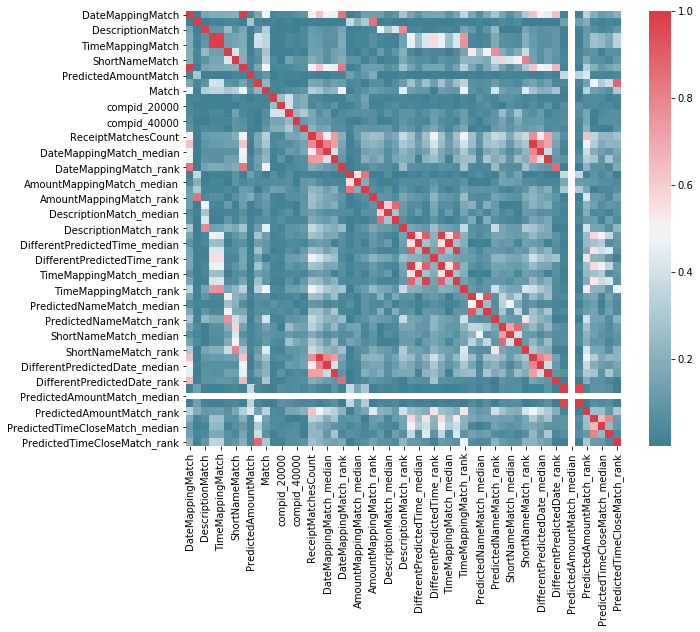

In [16]:
fig, axes = plt.subplots(figsize=(10, 8))
corr = train_df_scaled.corr().abs()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), 
            cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=axes); plt.show()

Top 10 highly correlated features with outcome variable

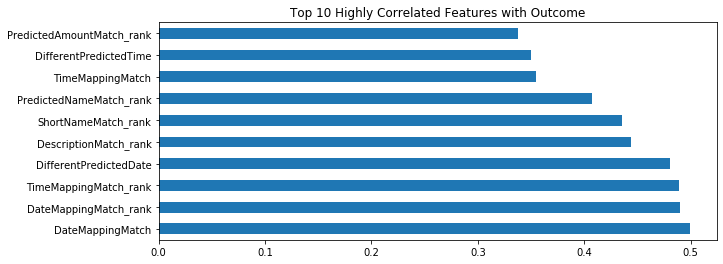

In [17]:
temp_df = corr.loc['Match'].sort_values(ascending=False)[1:11]
High_correl_features = temp_df.index.values.tolist()
temp_df.plot(kind='barh'); plt.title("Top 10 Highly Correlated Features with Outcome"); plt.show()

SelectKbest with Anova Analysis

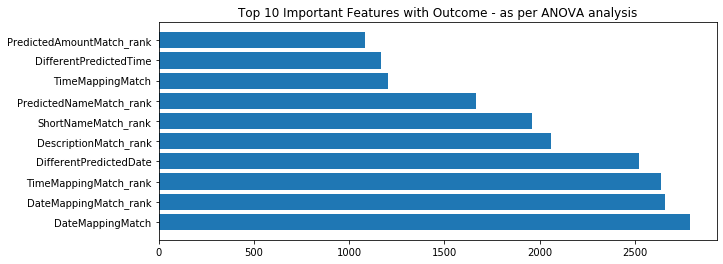

In [18]:
kbest_df = perform_selectkbest(train_df_scaled,'Match','anova')
kbest_features_anova = kbest_df['FeatureName'].values.tolist()
plt.barh(kbest_df['FeatureName'],kbest_df['FeatureImportance']);
plt.title("Top 10 Important Features with Outcome - as per ANOVA analysis"); plt.show()

Model Analysis

Results with including all features

In [19]:
include_cols = train_df_scaled.columns
evaluate_models(train_df_scaled, test_df_scaled, 'Match')

,Model,Matching - F1,Balanced Accuracy,ROC_AUC_SCORE
1,RandomForest,0.756152,0.826818,0.982064
2,XGBoost,0.755940,0.837055,0.983464
4,AdaBoost,0.747863,0.836314,0.976303
0,Logistic,0.728477,0.817523,0.981622
5,MLP,0.641414,0.746120,0.976315
3,NaiveBayes,0.574713,0.815419,0.944220


Results with including only highly correlated features

In [20]:
include_cols = High_correl_features
include_cols.append('Match')
evaluate_models(train_df_scaled.loc[:,include_cols], test_df_scaled.loc[:,include_cols], 'Match')

,Model,Matching - F1,Balanced Accuracy,ROC_AUC_SCORE
2,XGBoost,0.753247,0.835102,0.984025
1,RandomForest,0.746067,0.820810,0.977775
4,AdaBoost,0.731501,0.831370,0.975059
0,Logistic,0.691415,0.787163,0.975699
3,NaiveBayes,0.677903,0.839141,0.969623
5,MLP,0.511494,0.673384,0.975428


Results with including only kbest best features from ANOVA Test

In [21]:
include_cols = kbest_features_anova
include_cols.append('Match')
evaluate_models(train_df_scaled.loc[:,include_cols], test_df_scaled.loc[:,include_cols], 'Match')

,Model,Matching - F1,Balanced Accuracy,ROC_AUC_SCORE
2,XGBoost,0.753247,0.835102,0.984025
1,RandomForest,0.746067,0.820810,0.977775
4,AdaBoost,0.731501,0.831370,0.975059
0,Logistic,0.691415,0.787163,0.975699
3,NaiveBayes,0.677903,0.839141,0.969623
5,MLP,0.511494,0.673384,0.975428


With the above metrics, we are seeing that including all features is resulting in better performance

Among the candidate models, XGBoost has overall better performance, so we will make use of that as final model

Class implementation for receipt match
- Please note that this is also repeated in the python program
- This is present in two places so that the same code could be executed directly from notebook

In [22]:
class receipt_match:
    outcome_feature = 'Match'
    data_split_seed = 123
    model_seed      = 1234
    
    def __init__(self,train_file):
        self.train_file     = train_file
        self.input_data     = pd.read_csv(train_file,delimiter=':', thousands=',')
        self.total_receipts = len(self.input_data['receipt_id'].unique())
        self.model_file     = None
        
    def model_stats(self,test_ratio):
        np.random.seed(self.data_split_seed)
        test_receipt_count  = round(self.total_receipts*test_ratio)
        train_receipt_count = self.total_receipts - test_receipt_count
        train_receipts      = np.random.choice(self.input_data['receipt_id'].unique(),
                                               train_receipt_count,replace=False).tolist()
        test_receipts  = [x for x in self.input_data['receipt_id'].unique().tolist() if x not in train_receipts]
        train_df       = self.input_data[self.input_data['receipt_id'].isin(train_receipts)]
        test_df        = self.input_data[self.input_data['receipt_id'].isin(test_receipts)]

        train_df = self.FeatureEngineering(train_df); test_df = self.FeatureEngineering(test_df)
        drop_cols = ['receipt_id']
        train_df.drop(drop_cols,axis=1,inplace=True); test_df.drop(drop_cols,axis=1,inplace=True)
        
        scaler = MinMaxScaler(); scaler.fit(train_df)
        train_df_scaled = pd.DataFrame(scaler.transform(train_df),columns=train_df.columns)
        test_df_scaled  = pd.DataFrame(scaler.transform(test_df),columns=test_df.columns)
        
        X_train  = train_df_scaled.loc[:,train_df_scaled.columns != self.outcome_feature]
        y_train  = train_df_scaled.loc[:,train_df_scaled.columns == self.outcome_feature]
        X_test   = test_df_scaled.loc[:,test_df_scaled.columns != self.outcome_feature]
        y_test   = test_df_scaled.loc[:,test_df_scaled.columns == self.outcome_feature]
        
        xgb_clf = XGBClassifier(max_depth=10,random_state=self.model_seed,n_estimators=100,n_jobs=-1)
        xgb_clf.fit(X_train, y_train);
        
        predictions    = xgb_clf.predict(X_test)
        predict_proba  = xgb_clf.predict_proba(X_test)[:,1]
        
        metric_f1 = round(f1_score(y_test,predictions,average=None).tolist()[1],3)
        bal_acc   = round(balanced_accuracy_score(y_test,predictions),3)
        roc_score = round(roc_auc_score(y_test,predict_proba),3)
        
        print("Model Info:",xgb_clf)
        
        print("Model Metrics:\nF1-Score:",metric_f1,
              "\nBalanced Accuracy:", bal_acc, 
              "\nROC_AUC_Score:", roc_score)
        
    def FeatureEngineering(self,temp_df):
        
        #Match Feature
        if (('matched_transaction_id' in temp_df.columns) and 
            ('feature_transaction_id' in temp_df.columns)):
            temp_df['Match'] = temp_df.apply(lambda row: 1 \
                                            if row['matched_transaction_id'] == row['feature_transaction_id'] \
                                            else 0, axis = 1)
        #CompanyID OneHotEncoding
        temp_df = pd.concat([temp_df,pd.get_dummies(temp_df['company_id'],
                                                    prefix='compid')],axis=1).drop('company_id',axis=1)

        #ReceiptMatchesCount
        receipt_counts = temp_df.groupby(['receipt_id']).size().to_dict()
        temp_df['ReceiptMatchesCount'] = temp_df.apply(lambda row: receipt_counts[row['receipt_id']],axis=1)

        feature_list = ['DateMappingMatch','AmountMappingMatch','DescriptionMatch',
                        'DifferentPredictedTime', 'TimeMappingMatch', 'PredictedNameMatch', 
                        'ShortNameMatch', 'DifferentPredictedDate', 'PredictedAmountMatch', 'PredictedTimeCloseMatch']

        #StatisticsFeatures
        mean_df   = temp_df.groupby(['receipt_id']).mean()
        median_df = temp_df.groupby(['receipt_id']).median()
        std_df    = temp_df.groupby(['receipt_id']).std()
        rank_df   = temp_df.groupby(['receipt_id']).rank(pct=True)
        for each_feature in feature_list:
            temp_dict = mean_df[each_feature].to_dict()
            temp_df[each_feature+'_mean']   = temp_df.apply(lambda row: temp_dict[row['receipt_id']],axis=1)
            temp_dict = median_df[each_feature].to_dict()
            temp_df[each_feature+'_median'] = temp_df.apply(lambda row: temp_dict[row['receipt_id']],axis=1)
            temp_dict = std_df[each_feature].to_dict()
            temp_df[each_feature+'_std']    = temp_df.apply(lambda row: temp_dict[row['receipt_id']],axis=1).fillna(0)
            temp_df[each_feature+'_rank']   = rank_df[each_feature]

        #Drop feature_transaction_id and matched_transaction_id columns
        for each_col in ['feature_transaction_id','matched_transaction_id']:
            if each_col in temp_df.columns:
                temp_df.drop(each_col,axis=1,inplace=True)
                
        return temp_df
        
    def fit(self,model_file):
        self.model_file = model_file
        feature_eng_df = self.FeatureEngineering(self.input_data)
        feature_eng_df.drop(['receipt_id'],axis=1,inplace=True)
        X_train  = feature_eng_df.loc[:,feature_eng_df.columns != self.outcome_feature]
        y_train  = feature_eng_df.loc[:,feature_eng_df.columns == self.outcome_feature]
        self.scaler = MinMaxScaler()
        self.scaler.fit(X_train)
        X_train_scaled = pd.DataFrame(self.scaler.transform(X_train),columns=X_train.columns)
        self.xgb_clf = XGBClassifier(max_depth=10,random_state=self.model_seed,n_estimators=100,n_jobs=-1)
        self.xgb_clf.fit(X_train_scaled, y_train)
        pickle.dump(self.xgb_clf, open(model_file, 'wb'))
        
    def predict(self,validation_file,predictions_file):
        if self.model_file is None:
            print("Please fit the model before making predictions")
        else:
            if path.exists(validation_file):
                if self.xgb_clf is None:
                    self.xgb_clf = pickle.load(open(self.model_file,'rb'))
                val_df       = pd.read_csv(validation_file,delimiter=':', thousands=',')
                fe_df        = self.FeatureEngineering(val_df).drop(['receipt_id'],axis=1)
                fe_df_scaled = pd.DataFrame(self.scaler.transform(fe_df),columns=fe_df.columns)
                X_test       = fe_df_scaled.loc[:,fe_df_scaled.columns != self.outcome_feature]
                y_predict_proba = self.xgb_clf.predict_proba(X_test)[:,1]
                val_df['Match_Probability'] = y_predict_proba
                val_df = val_df.groupby(['receipt_id']).apply(lambda x: x.sort_values(['Match_Probability'],
                                                              ascending=False)).reset_index(drop=True)
                val_df.drop(['Match_Probability'],axis=1,inplace=True)
                val_df.to_csv(predictions_file,index=False)
            else:
                print("Validation file doesnt exist. Please check again")

Creating dummy test file same as input file for validation, with all columns except for matched_transaction_id

In [23]:
%%time
test_df = pd.read_csv('data.csv',delimiter=':', thousands=',')
test_df.drop(['matched_transaction_id'],axis=1,inplace=True)
test_df.to_csv('validation_file.csv',sep=':',index=False)

CPU times: user 124 ms, sys: 13.3 ms, total: 137 ms
Wall time: 136 ms


Dry run of the receipt_match module with the validation file created above

In [24]:
%%time
obj1 = receipt_match("data.csv")
obj1.model_stats(0.3)
obj1.fit('model_file.pk')
obj1.predict('validation_file.csv','predictions.csv')

Model Info: XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=1234,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)
Model Metrics:
F1-Score: 0.756 
Balanced Accuracy: 0.837 
ROC_AUC_Score: 0.983
CPU times: user 28.7 s, sys: 586 ms, total: 29.3 s
Wall time: 29.7 s


Check Results of prediction if the ordering is appropriate

In [26]:
predictions_df = pd.read_csv('predictions.csv')
predictions_df.tail(10)

,receipt_id,company_id,feature_transaction_id,DateMappingMatch,AmountMappingMatch,DescriptionMatch,DifferentPredictedTime,TimeMappingMatch,PredictedNameMatch,ShortNameMatch,DifferentPredictedDate,PredictedAmountMatch,PredictedTimeCloseMatch
12024,50225,50000,50005,0.00,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
12025,50225,50000,50003,0.00,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
12026,50225,50000,50026,0.00,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
12027,50226,50000,50368,0.95,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
12028,50226,50000,50074,0.65,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
12029,50226,50000,50075,0.65,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
12030,50226,50000,50070,0.00,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
12031,50226,50000,50072,0.00,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
12032,50226,50000,50367,0.00,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
12033,50226,50000,50366,0.00,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
